In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix)

import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Analyzing the Data

In [2]:
df = pd.read_csv("smart_grid_stability_augmented.csv")
table = dict() # used for storing accuracy, precision, recall, f1score of each model
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB


In [4]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403


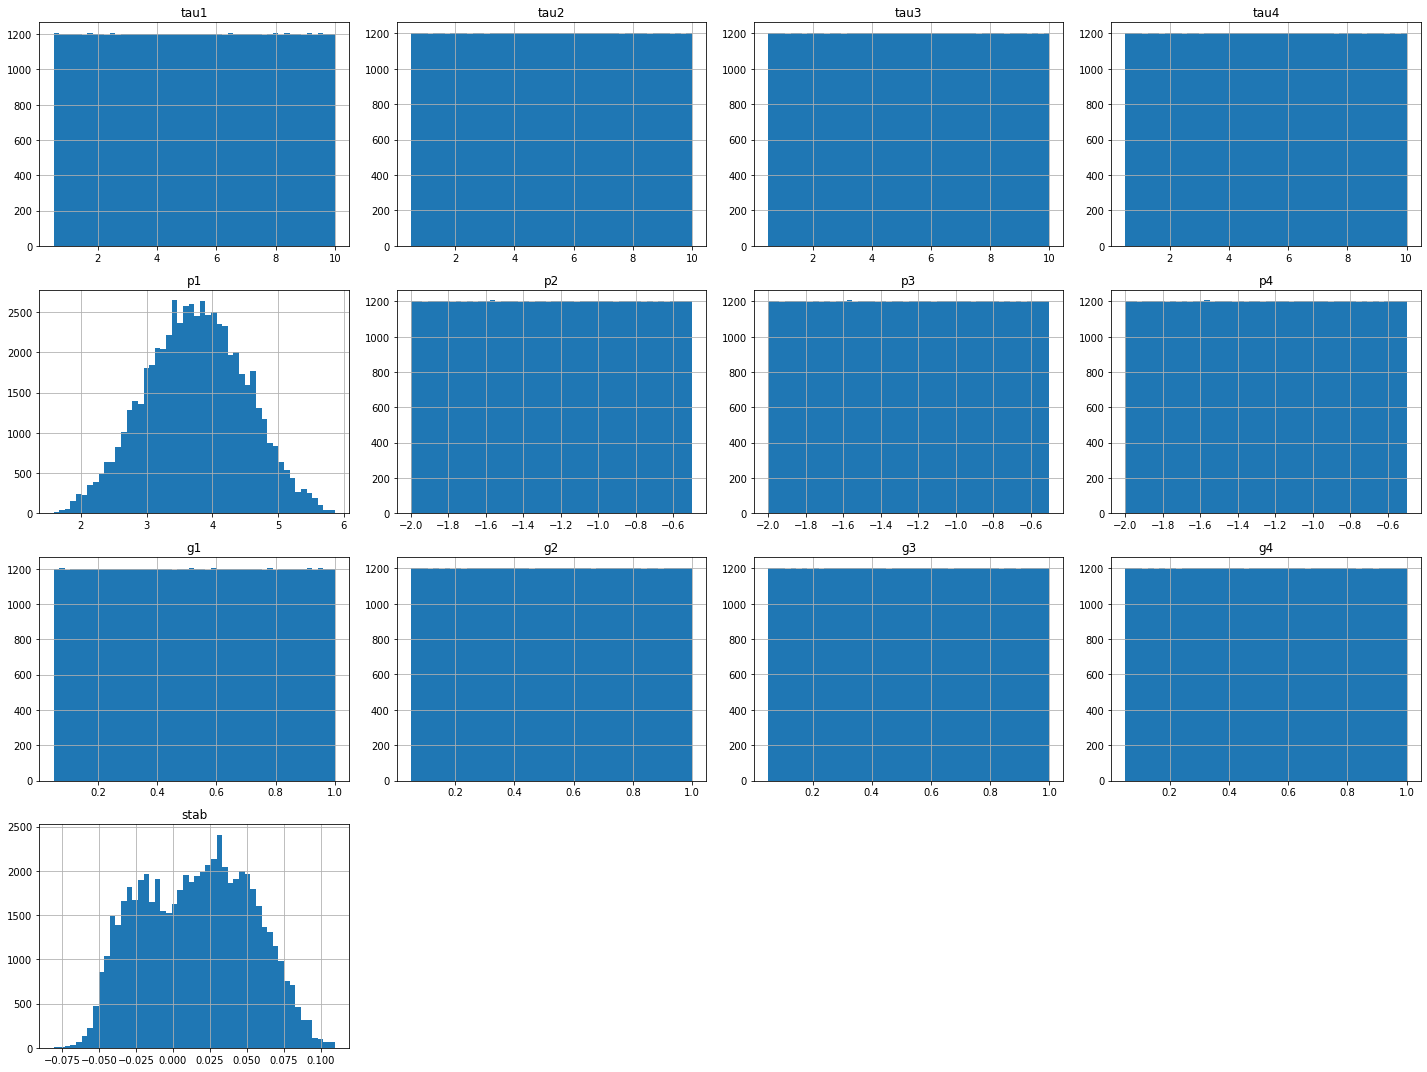

In [5]:
df.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

In [6]:
df['stabf'] = df['stabf'].map({
    'stable': 1,
    'unstable': 0
})
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


In [7]:
y = df.iloc[:, -1]
X = df.drop('stabf', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 156)

In [8]:
X_train.shape, y_train.shape

((48000, 13), (48000,))

In [9]:
X_test.shape, y_test.shape

((6000, 13), (6000,))

In [10]:
X_val.shape, y_val.shape

((6000, 13), (6000,))

In [11]:
pca = PCA(n_components=2)
x2d = pca.fit_transform(X)
x2d_df = pd.DataFrame(x2d)

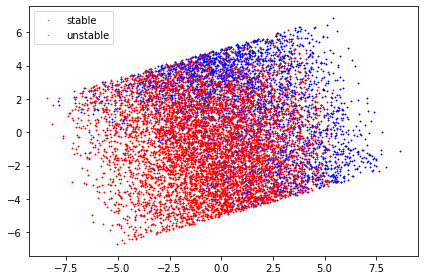

In [12]:
plt.plot(x2d_df[0][y==1], x2d_df[1][y==1], 'b.', ms=0.6, label='stable')
plt.plot(x2d_df[0][y==0], x2d_df[1][y==0], 'r.', ms=0.6, label='unstable')
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [13]:
def draw_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index=['unstable', 'stable'], columns=['unstable', 'stable'])
    cm_sns = sns.heatmap(cm, cmap="Blues", annot=True)
    cm_sns.set_xlabel('predicted')
    cm_sns.set_ylabel('actual')
    plt.show()

# Logistic Regression

In [14]:
log_pipe = Pipeline([
    ('std_scl', StandardScaler()), ('log_reg', LogisticRegression())
])
log_pipe.fit(X_train, y_train)
accuracy_score(y_train, log_pipe.predict(X_train))

0.9993333333333333

In [15]:
accuracy_score(y_val, log_pipe.predict(X_val))

0.9996666666666667

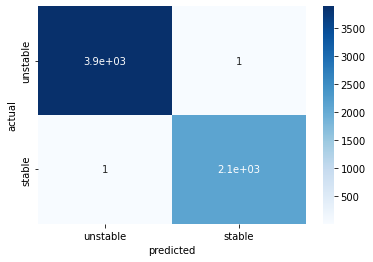

In [16]:
draw_cm(y_val, log_pipe.predict(X_val))

In [17]:
table["Logistic Regression"] = (accuracy_score(y_test, log_pipe.predict(X_test)), 
                               precision_score(y_test, log_pipe.predict(X_test)), 
                               recall_score(y_test, log_pipe.predict(X_test)),
                               f1_score(y_test, log_pipe.predict(X_test)))

# XGBoost

In [18]:
xgb_clf = XGBClassifier(n_jobs=-1, use_label_encoder=False)
xgb_clf.fit(X_train, y_train)
accuracy_score(y_train, xgb_clf.predict(X_train))

[23:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1.0

In [19]:
accuracy_score(y_val, xgb_clf.predict(X_val))

1.0

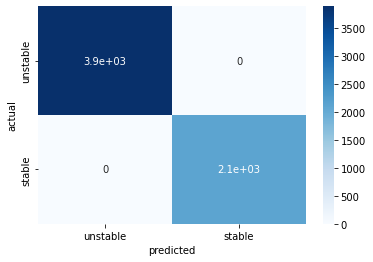

In [20]:
draw_cm(y_val, xgb_clf.predict(X_val))

In [21]:
table["XG Boost"] = (accuracy_score(y_test, xgb_clf.predict(X_test)), 
                               precision_score(y_test, xgb_clf.predict(X_test)), 
                               recall_score(y_test, xgb_clf.predict(X_test)),
                               f1_score(y_test, xgb_clf.predict(X_test)))

# Linear SVM

In [22]:
svm_pipe = Pipeline([
    ('std_scl', StandardScaler()), ('svm', LinearSVC())
])
svm_pipe.fit(X_train, y_train)
accuracy_score(y_train, svm_pipe.predict(X_train))

0.9994791666666667

In [23]:
accuracy_score(y_val, svm_pipe.predict(X_val))

0.9991666666666666

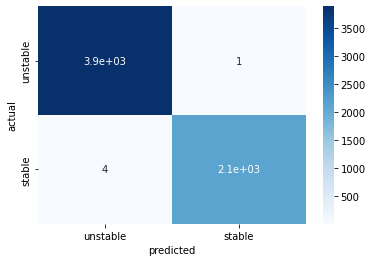

In [24]:
draw_cm(y_val, svm_pipe.predict(X_val))

In [25]:
table["Linear SVM"] = (accuracy_score(y_test, svm_pipe.predict(X_test)), 
                               precision_score(y_test, svm_pipe.predict(X_test)), 
                               recall_score(y_test, svm_pipe.predict(X_test)),
                               f1_score(y_test, svm_pipe.predict(X_test)))

# SVM with RBF Kernel

In [26]:
svm = Pipeline([
    ('std_scl', StandardScaler()), ('svm', SVC(kernel='rbf'))
])
svm.fit(X_train, y_train)
accuracy_score(y_train, svm.predict(X_train))

0.9963958333333334

In [27]:
accuracy_score(y_val, svm.predict(X_val))

0.9945

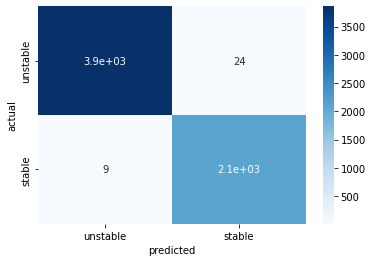

In [28]:
draw_cm(y_val, svm.predict(X_val))

In [29]:
table["SVM - RBF kernel"] = (accuracy_score(y_test, svm.predict(X_test)), 
                               precision_score(y_test, svm.predict(X_test)), 
                               recall_score(y_test, svm.predict(X_test)),
                               f1_score(y_test, svm.predict(X_test)))

# Neural Network

In [30]:
check_pointss = ModelCheckpoint("MinorProject_sgs.h5")

early_stoppingg = EarlyStopping(patience=10, restore_best_weights=True)

In [31]:
nn_clf = tf.keras.models.Sequential([
    InputLayer(input_shape=13),
    BatchNormalization(),
    Dense(units=64, activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid')
], name='nn_clf')
nn_clf.summary()

Model: "nn_clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 13)               52        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 17,845
Trainable params: 17,819
Non-trainable params: 26
_________________________________________________________________


In [32]:
nn_clf.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [33]:
history = nn_clf.fit(X_train, y_train, epochs=40, 
                    validation_data = (X_val, y_val), callbacks=[check_pointss, early_stoppingg])

Epoch 1/40
1500/1500 [==============================] - 6s 3ms/step - loss: 0.1209 - accuracy: 0.9490 - val_loss: 0.0437 - val_accuracy: 0.9900
Epoch 2/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0958 - accuracy: 0.9585 - val_loss: 0.0434 - val_accuracy: 0.9840
Epoch 3/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0953 - accuracy: 0.9591 - val_loss: 0.0417 - val_accuracy: 0.9877
Epoch 4/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0951 - accuracy: 0.9584 - val_loss: 0.0474 - val_accuracy: 0.9928
Epoch 5/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0904 - accuracy: 0.9617 - val_loss: 0.0379 - val_accuracy: 0.9870
Epoch 6/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0897 - accuracy: 0.9616 - val_loss: 0.0413 - val_accuracy: 0.9908
Epoch 7/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0898 - accuracy: 0.9613 - val_loss: 0.0387 - val_accuracy:

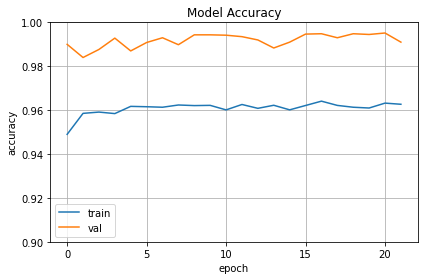

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.grid(True)
plt.gca().set_ylim(0.9, 1.0)
plt.tight_layout()
plt.show()

In [35]:
accuracy_score(y_test, (nn_clf.predict(X_test) > 0.5))

0.9918333333333333

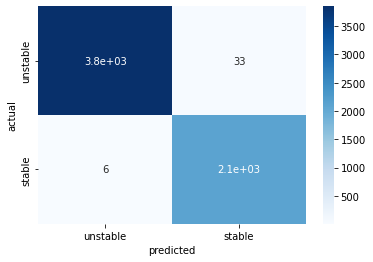

In [36]:
draw_cm(y_val, (nn_clf.predict(X_val) > 0.5))

In [38]:
table["Neural Network"] = (accuracy_score(y_test, (nn_clf.predict(X_test) > 0.5)), 
                               precision_score(y_test, (nn_clf.predict(X_test) > 0.5)), 
                               recall_score(y_test, (nn_clf.predict(X_test) > 0.5)),
                               f1_score(y_test, (nn_clf.predict(X_test) > 0.5)))

In [39]:
pd.DataFrame(table, index=["accuracy", "precision", "recall", "f1score"])

,Logistic Regression,XG Boost,Linear SVM,SVM - RBF kernel,Neural Network
accuracy,0.999333,1.0,0.999333,0.993500,0.991833
precision,1.000000,1.0,1.000000,0.992701,0.985547
recall,0.998181,1.0,0.998181,0.989541,0.992269
f1score,0.999090,1.0,0.999090,0.991118,0.988896
